In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Preparación de los datos

In [48]:
# Especificar los tipos de datos para las columnas problemáticas
dtype_dict = {
    'gpu_spec': 'string', 
    'qos': 'string',
    'pod_phase': 'string'
}

extracted_data = pd.read_csv('data/concatenated_openb_pod_all.csv', dtype=dtype_dict)

extracted_data.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,source_file
0,openb-pod-0000,12000,16384,1,1000,<NA>,LS,Running,0.0,12537496.0,0.0,openb_pod_list_cpu0.csv
1,openb-pod-0001,6000,12288,1,460,<NA>,LS,Running,427061.0,12902960.0,427061.0,openb_pod_list_cpu0.csv
2,openb-pod-0002,12000,24576,1,1000,<NA>,LS,Running,1558381.0,12902960.0,1558381.0,openb_pod_list_cpu0.csv
3,openb-pod-0003,6000,12288,1,460,<NA>,LS,Running,2690044.0,12902960.0,2690044.0,openb_pod_list_cpu0.csv
4,openb-pod-0004,12000,16384,1,1000,<NA>,LS,Running,2758084.0,12902960.0,2758084.0,openb_pod_list_cpu0.csv


In [49]:
extracted_data.describe()

,cpu_milli,memory_mib,num_gpu,gpu_milli,creation_time,deletion_time,scheduled_time
count,199197.000000,199197.000000,199197.000000,199197.000000,1.645580e+05,1.645580e+05,1.458250e+05
mean,10717.539280,38222.719032,0.949839,678.128436,1.146626e+07,1.149092e+07,1.144099e+07
std,9898.142775,40961.400145,0.828167,366.365105,9.626859e+05,9.035249e+05,9.682643e+05
min,1000.000000,0.000000,0.000000,0.000000,0.000000e+00,9.538584e+06,0.000000e+00
25%,4000.000000,15258.000000,1.000000,460.000000,1.069520e+07,1.070431e+07,1.066806e+07
50%,11300.000000,33792.000000,1.000000,810.000000,1.147048e+07,1.148005e+07,1.141606e+07
75%,12000.000000,49152.000000,1.000000,1000.000000,1.228024e+07,1.229824e+07,1.225873e+07
max,120200.000000,737280.000000,8.000000,1000.000000,1.290176e+07,1.290296e+07,1.290176e+07


In [50]:
extracted_data.describe(include=['string','object'])

,name,gpu_spec,qos,pod_phase,source_file
count,199197,6692,164558,164558,199197
unique,10094,17,4,4,24
top,openb-pod-7063,T4,LS,Running,openb_pod_list_cpu300.csv
freq,24,3474,88493,103210,10094


In [51]:
extracted_data.isnull().sum()


name                   0
cpu_milli              0
memory_mib             0
num_gpu                0
gpu_milli              0
gpu_spec          192505
qos                34639
pod_phase          34639
creation_time      34639
deletion_time      34639
scheduled_time     53372
source_file            0
dtype: int64

In [52]:
filtered_data = extracted_data[
    (extracted_data['scheduled_time'] > 0) & 
    (extracted_data['pod_phase'] != 'Running')&
    (extracted_data['memory_mib'] > 0) 
]
#filtered_data = filtered_data.rename(columns={'num_gpu': 'workers'})

pod_phase_counts = filtered_data['pod_phase'].value_counts()

print(pod_phase_counts)

pod_phase
Failed       39209
Succeeded     3388
Name: count, dtype: Int64


In [53]:
# Mostrar los resultados
print('Registros Originales:', len(extracted_data))
print('Registros totales:', len(filtered_data))

Registros Originales: 199197
Registros totales: 42597


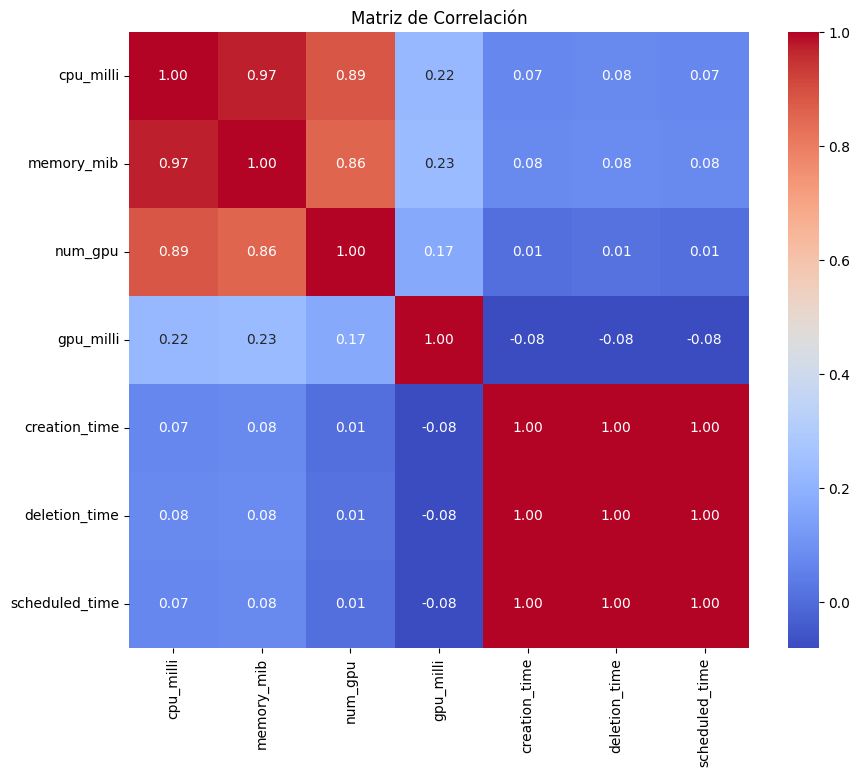

In [54]:
# Selecciona solo las columnas numéricas para calcular la correlación
numeric_df = filtered_data.select_dtypes(include=['number'])

# Calcula la matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación con un mapa de calor
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [55]:
# Mantener la primera versión de un registro duplicado en un nuevo dataframe
no_dups_df = filtered_data.drop_duplicates(keep='first', inplace=False)

# Contar duplicados
dups_rows = filtered_data[filtered_data.duplicated(keep='first')]

# Calcular el porcentaje de duplicados
porcentaje_dups = (dups_rows.shape[0] / filtered_data.shape[0]) * 100

# Imprimir resultados:
print(f'Cantidad de Registros Originales: {filtered_data.shape[0]}')
print(f"Cantidad de Registros duplicados: {dups_rows.shape[0]}")
print(f"Porcentaje de duplicados sobre la muestra original: {porcentaje_dups:.2f}%")
print(f"Cantidad de Registros sin dups  : {no_dups_df.shape[0]}")


Cantidad de Registros Originales: 42597
Cantidad de Registros duplicados: 0
Porcentaje de duplicados sobre la muestra original: 0.00%
Cantidad de Registros sin dups  : 42597


In [56]:
data = filtered_data.copy()

# Reemplazar valores <NA> con '0' en columnas de tipo string
for col in data.select_dtypes(include=['string']).columns:
    data[col] = data[col].fillna('0')

# Reemplazar valores <NA> con 0 en columnas numéricas
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(0)

data.fillna(0, inplace=True)  


In [57]:
# Agregar columnas adicionales para el análisis

# Convierte miliCPU a cores
data["cpu_cores"] = data["cpu_milli"] / 1000    
# Convierte miliGPU a cores
data["gpu_cores"] = data["gpu_milli"] / 1000    
# Convertir MiB a GiB
data['memory_gbs'] = data['memory_mib'] / 1024  
# Calcula el uso total de CPU y GPU en cores
data["total_usage"] = data["cpu_cores"] + data["gpu_cores"] 
# Calcula la relación entre el uso de CPU y GPU (evitando la división por cero)
data["cpu_gpu_ratio"] = data["cpu_cores"] / (data["gpu_cores"] + 1e-6) 


- La conversión de miliCPU y miliGPU a cores se realizó para expresar el uso de recursos en una unidad más interpretable.
- La variable total_usage se creó para tener una medida agregada del consumo de recursos, lo que puede ser útil para simplificar el modelado.
- La variable cpu_gpu_ratio se calculó para analizar cómo se balancea el uso de CPU y GPU, lo que puede proporcionar información sobre la eficiencia de las tareas.

In [58]:
data[['cpu_cores', 'memory_gbs','gpu_cores','total_usage', 'cpu_gpu_ratio']].describe()

,cpu_cores,memory_gbs,gpu_cores,total_usage,cpu_gpu_ratio
count,42597.000000,42597.000000,42597.000000,42597.000000,4.259700e+04
mean,6.238897,18.672637,0.848055,7.086952,6.095022e+04
std,11.314430,50.143444,0.154221,11.349417,1.138557e+06
min,3.152000,5.468750,0.000000,3.742000,3.151997e+00
25%,3.152000,5.468750,0.810000,3.962000,3.891353e+00
50%,3.152000,5.468750,0.810000,3.962000,3.891353e+00
75%,4.000000,10.351562,1.000000,4.522000,3.999996e+00
max,120.200000,720.000000,1.000000,121.200000,3.200000e+07


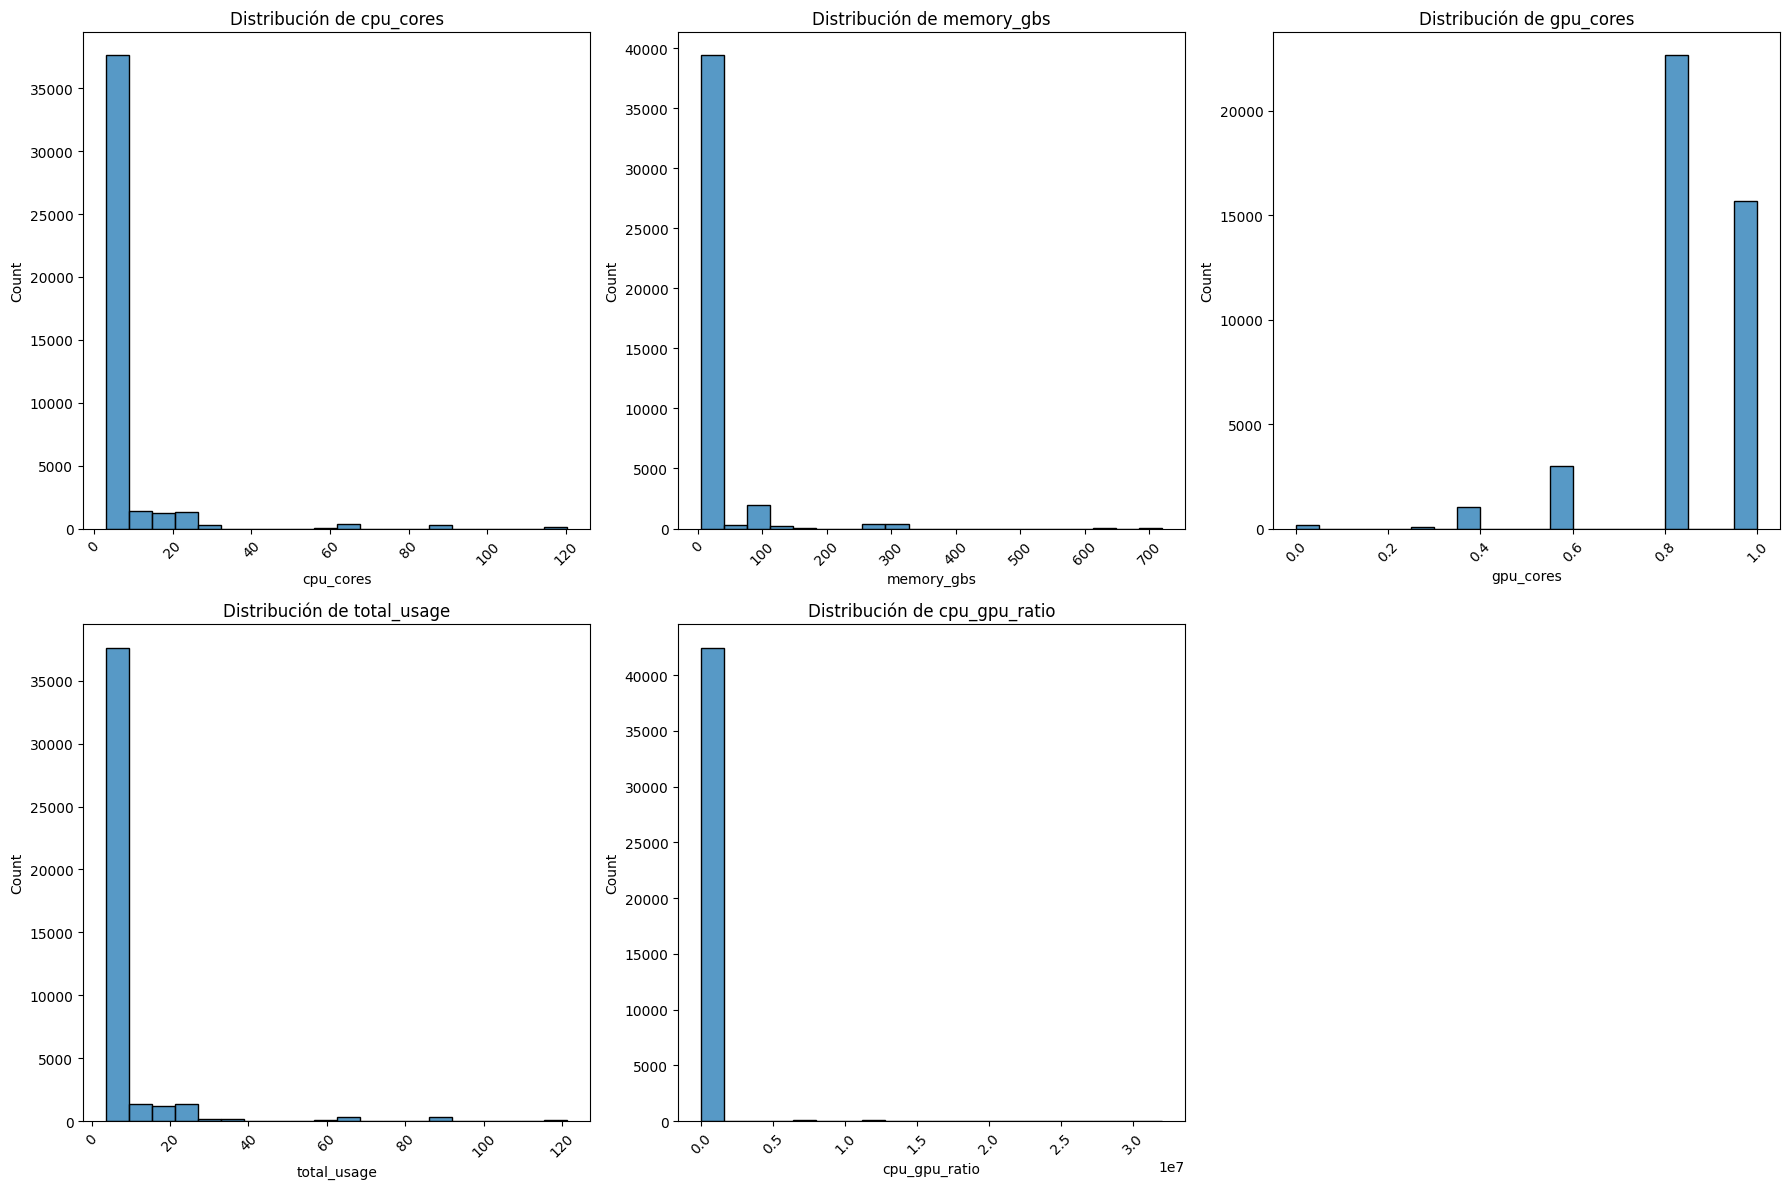

In [59]:
# Seleccionar columnas numéricas
numeric_data = data
numeric_columns = ['cpu_cores', 'memory_gbs','gpu_cores','total_usage', 'cpu_gpu_ratio'] 

subset_df = numeric_data[numeric_columns]

# Configurar subplots para mostrar 3 gráficos por fila
num_cols = 3
num_plots = len(subset_df.columns)
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))  # Ajustar tamaño
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, col in enumerate(subset_df.columns):
    sns.histplot(data=subset_df, x=col, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar gráficos vacíos si hay menos de num_rows * num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

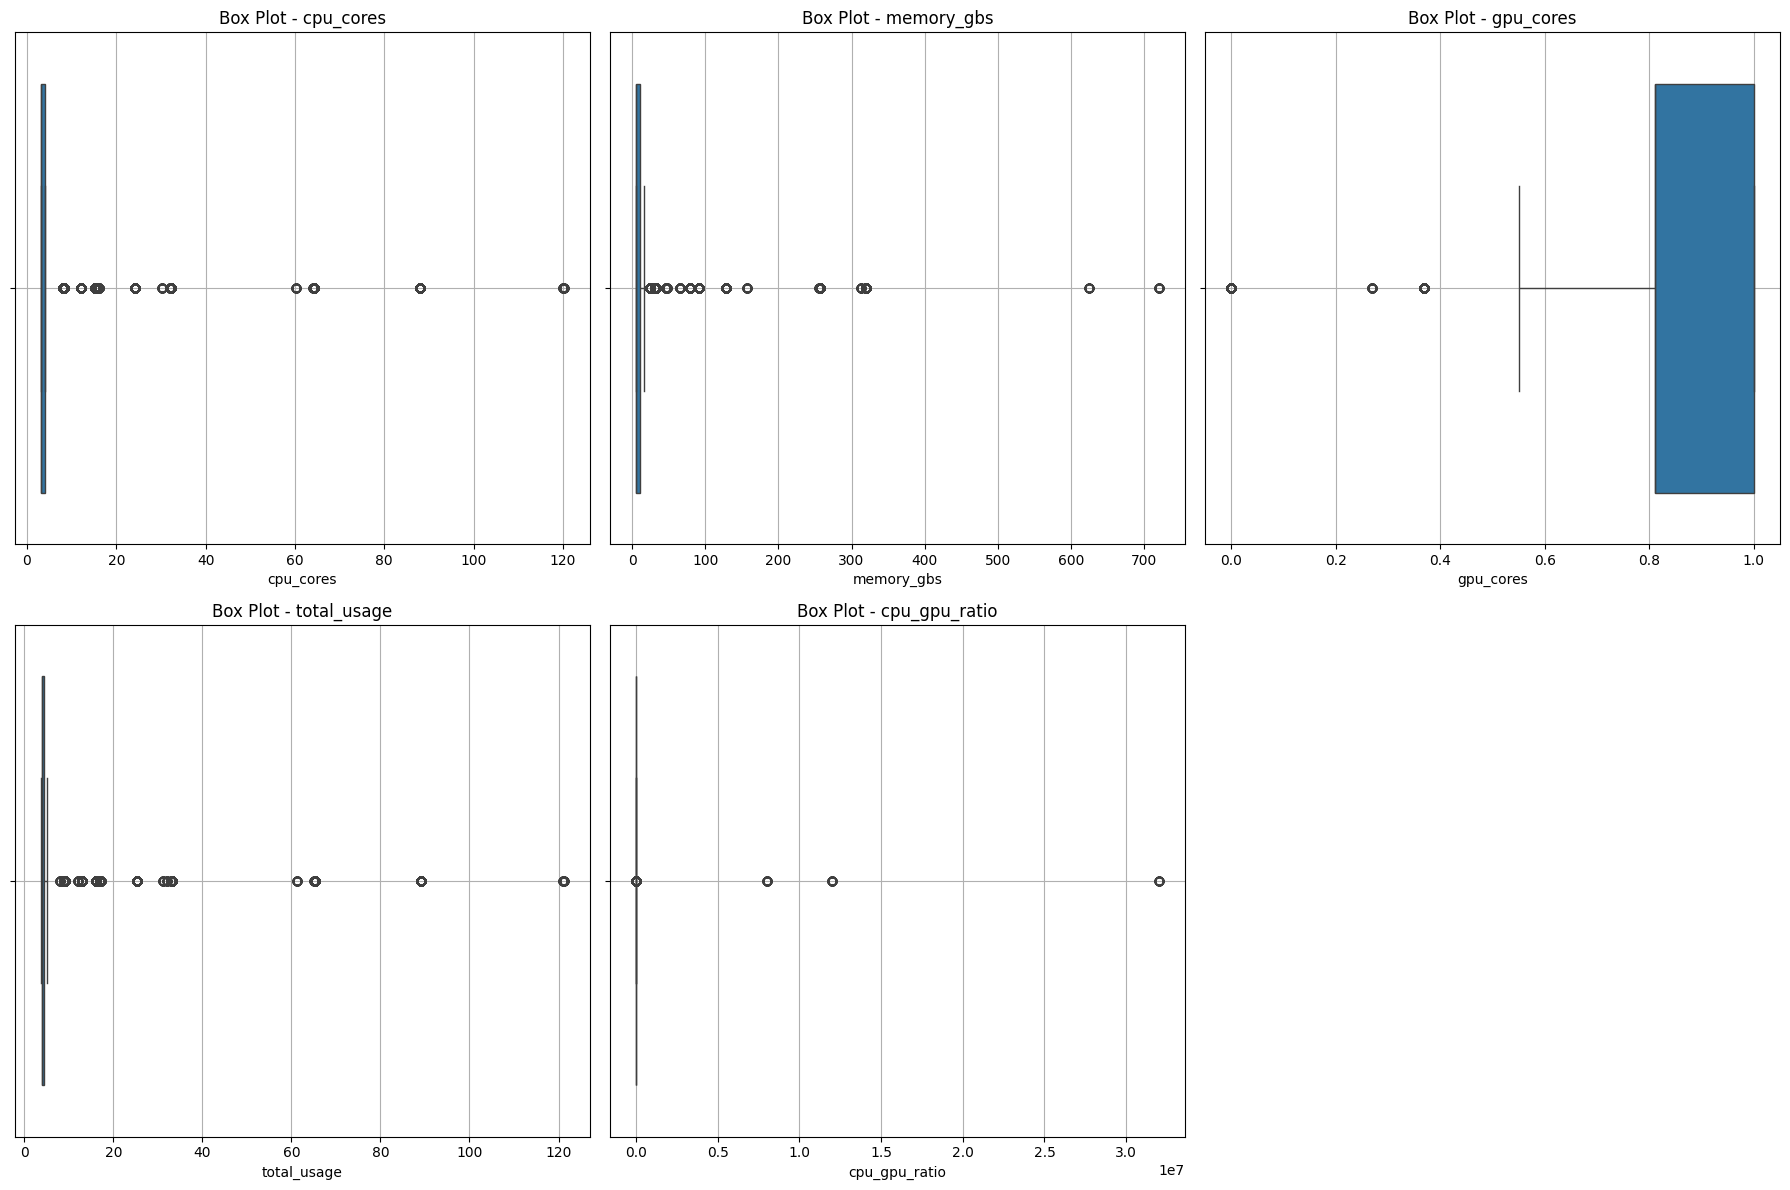

In [60]:
from utils.graph_boxplot import plot_boxplots
# Crear
box_plot_df = numeric_data[numeric_columns]
#box_plot_df = box_plot_df[box_plot_df['total_usage'] <= 40]

plot_boxplots(box_plot_df, numeric_columns )

### Manejo de outliers

Q1: cpu_cores        3.152000
memory_gbs       5.468750
gpu_cores        0.810000
total_usage      3.962000
cpu_gpu_ratio    3.891353
Name: 0.25, dtype: float64, Q3: cpu_cores         4.000000
memory_gbs       10.351562
gpu_cores         1.000000
total_usage       4.522000
cpu_gpu_ratio     3.999996
Name: 0.75, dtype: float64, IQR: cpu_cores        0.848000
memory_gbs       4.882812
gpu_cores        0.190000
total_usage      0.560000
cpu_gpu_ratio    0.108643
dtype: float64
Lower bound: cpu_cores        1.880000
memory_gbs      -1.855469
gpu_cores        0.525000
total_usage      3.122000
cpu_gpu_ratio    3.728389
dtype: float64, Upper bound: cpu_cores         5.272000
memory_gbs       17.675781
gpu_cores         1.285000
total_usage       5.362000
cpu_gpu_ratio     4.162960
dtype: float64
Filas originales: 42597, Filas filtradas: 42597


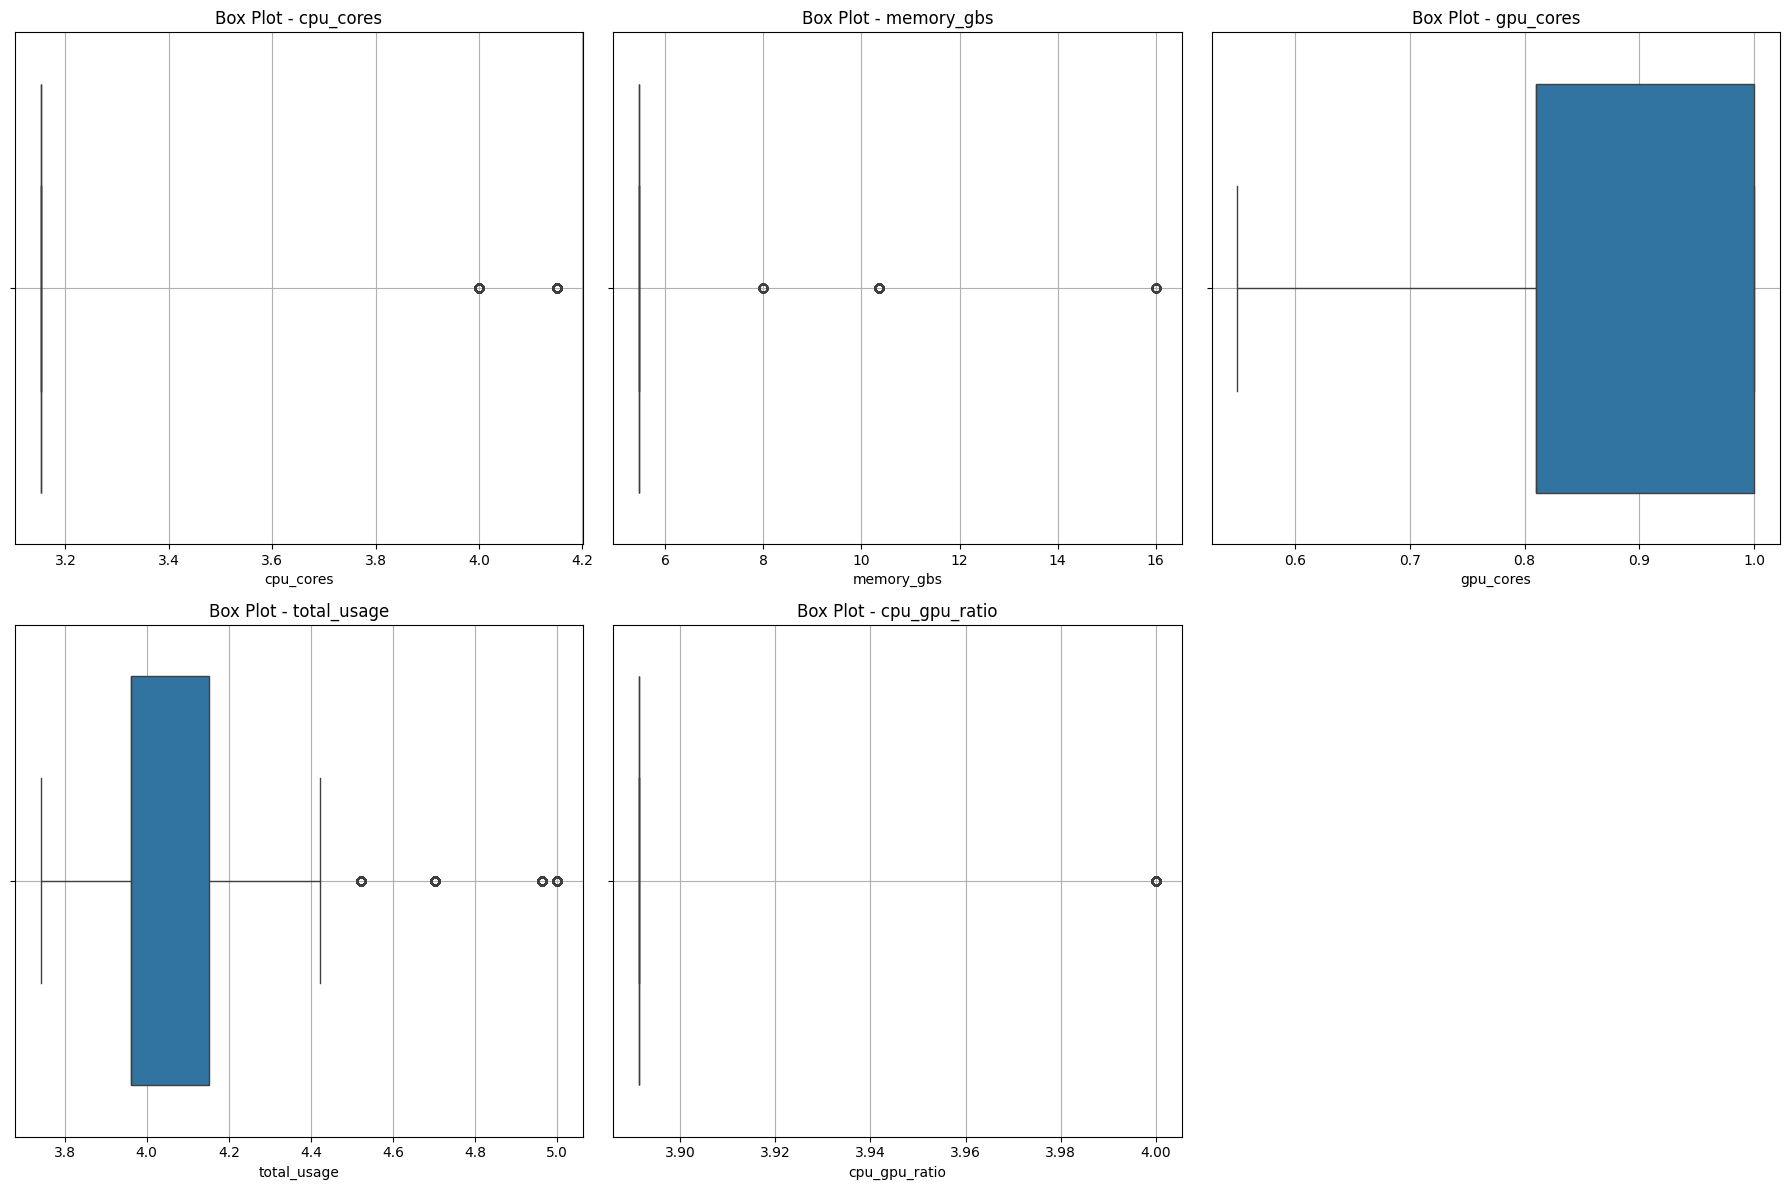

In [61]:
from utils.udf_outliers import remove_outliers_iqr, winsorize_outliers

outliers_df = data[['cpu_cores', 'memory_gbs','gpu_cores','total_usage', 'cpu_gpu_ratio']].copy()

iqr_outliers = remove_outliers_iqr(outliers_df, numeric_columns)

plot_boxplots(iqr_outliers, numeric_columns )

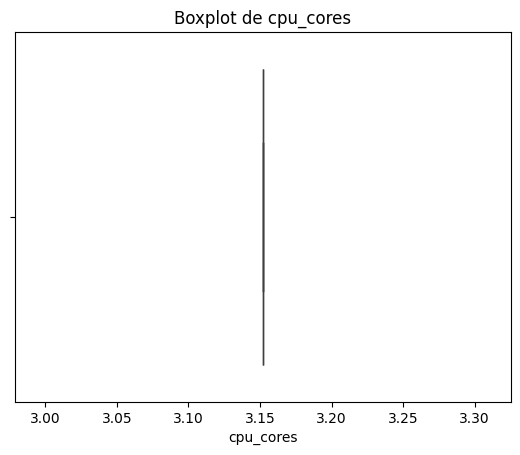

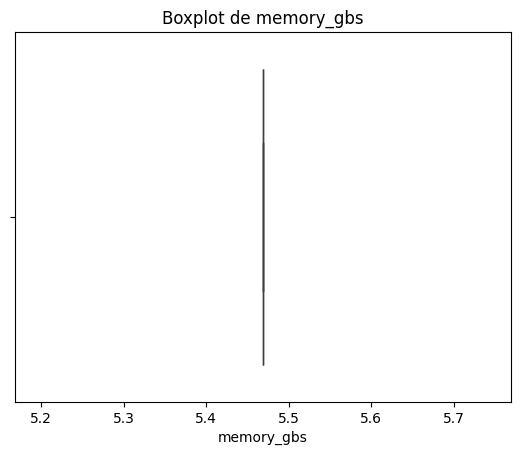

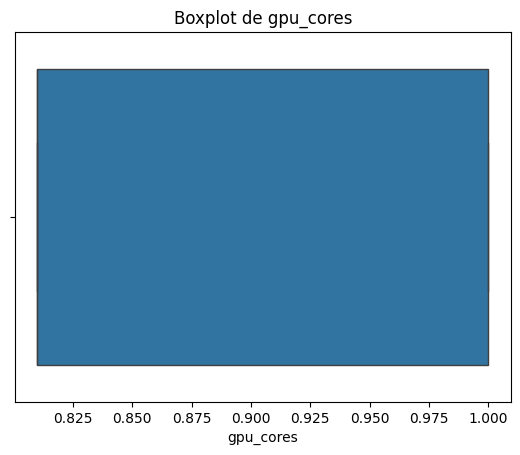

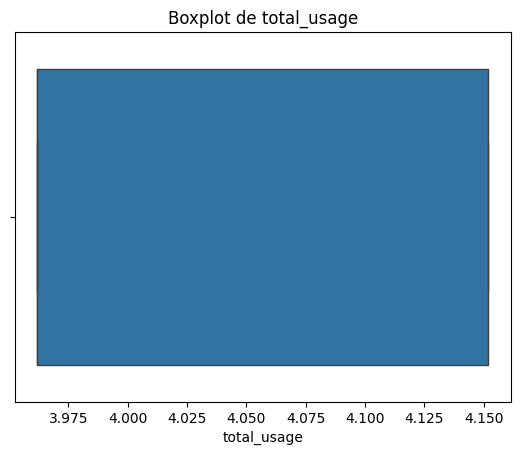

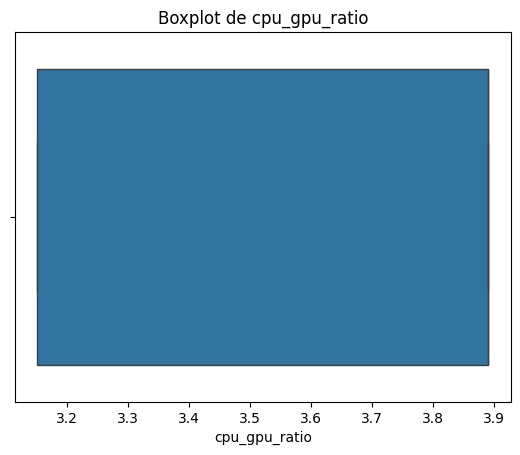

In [62]:
#Remover valores atípicos (outliers) por el metodo de IQR
def remove_outliers_iqr(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

df_no_outliers = remove_outliers_iqr(outliers_df, numeric_columns)

for column in numeric_columns:
  sns.boxplot(data=df_no_outliers, x=column)
  plt.title(f'Boxplot de {column}')
  plt.show()
  print('\n')


In [63]:
win_outliers = winsorize_outliers(outliers_df['gpu_cores'])
win_outliers.count()

np.int64(42597)

In [64]:
print(f"Dimensiones de outliers_df: {outliers_df.shape}")
print(f"Dimensiones de iqr_outliers: {iqr_outliers.shape}")

print(outliers_df.index.difference(iqr_outliers.index))


Dimensiones de outliers_df: (42597, 5)
Dimensiones de iqr_outliers: (42597, 5)
Index([], dtype='int64')


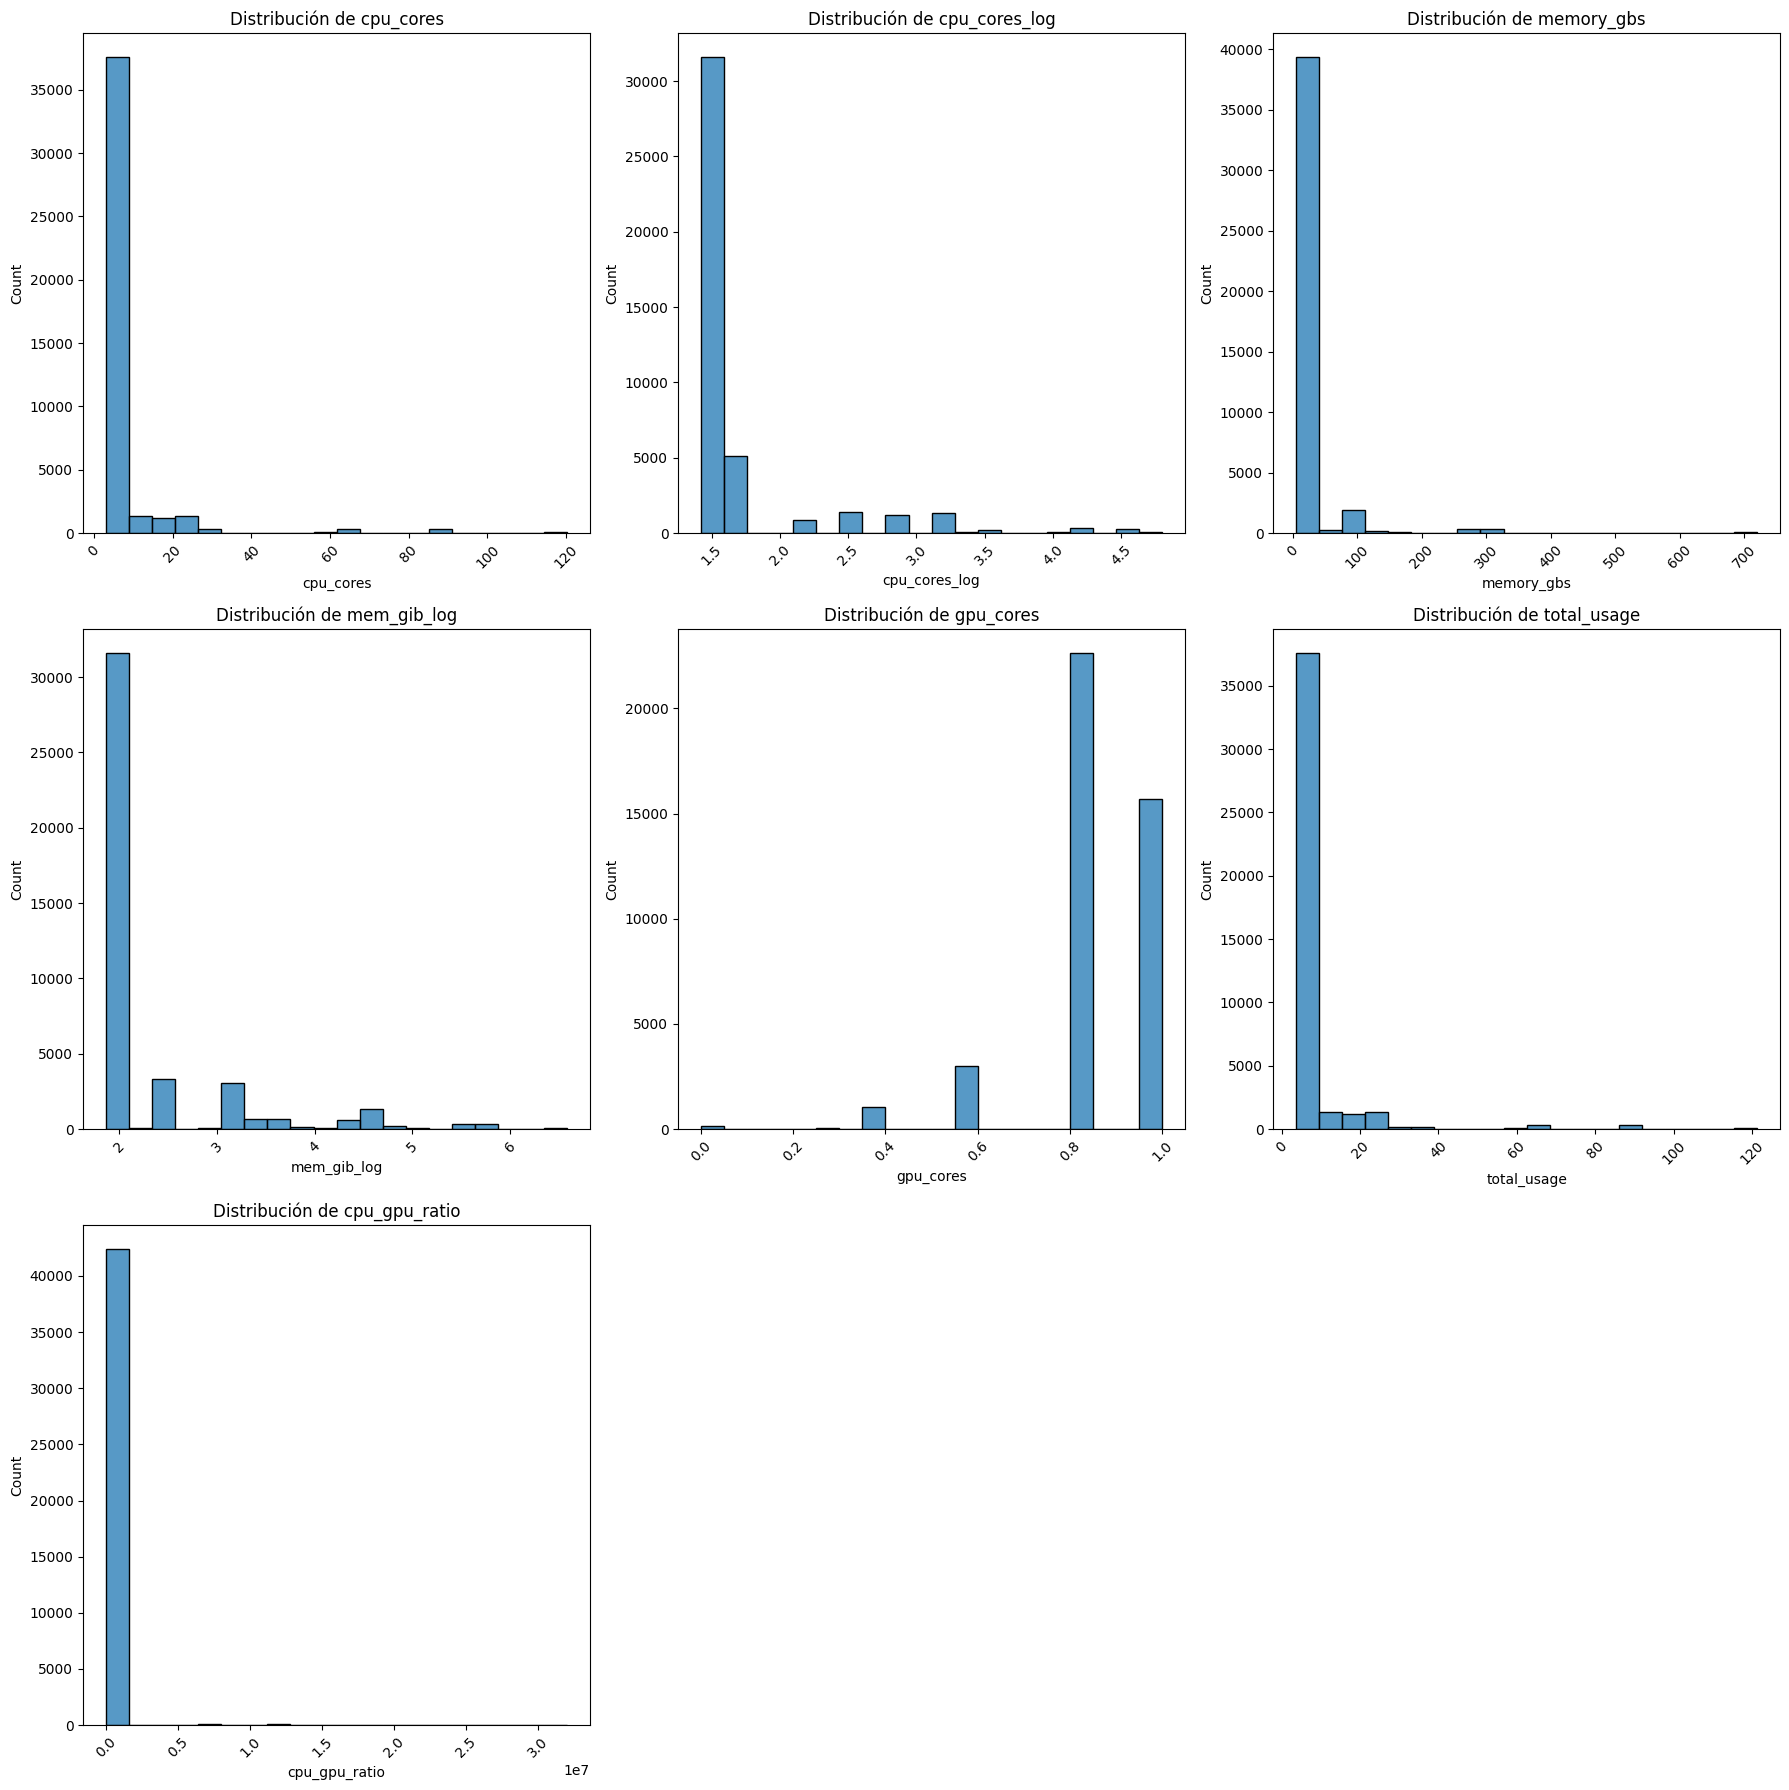

In [ ]:
import numpy as np 

df = data.copy()

df['cpu_cores_log'] = np.log1p(df['cpu_cores'])  # Maneja ceros y reduce outliers
df['mem_gib_log'] = np.log1p(df['memory_gbs'])  # Maneja ceros y reduce outliers




# Seleccionar columnas numéricas
numeric_data = df
numeric_columns = ['cpu_cores','cpu_cores_log', 'memory_gbs','mem_gib_log','gpu_cores','total_usage', 'cpu_gpu_ratio'] 

subset_df = numeric_data[numeric_columns]

# Configurar subplots para mostrar 3 gráficos por fila
num_cols = 3
num_plots = len(subset_df.columns)
num_rows = (num_plots + num_cols - 1) // num_cols  # Calcular el número de filas necesarias

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))  # Ajustar tamaño
axes = axes.flatten()  # Aplanar los ejes para iterar fácilmente

for i, col in enumerate(subset_df.columns):
    sns.histplot(data=subset_df, x=col, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar gráficos vacíos si hay menos de num_rows * num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [80]:
df[['cpu_cores','cpu_cores_log', 'memory_gbs','mem_gib_log','gpu_cores','total_usage', 'cpu_gpu_ratio']].describe()

,cpu_cores,cpu_cores_log,memory_gbs,mem_gib_log,gpu_cores,total_usage,cpu_gpu_ratio
count,42597.000000,42597.000000,42597.000000,42597.000000,42597.000000,42597.000000,4.259700e+04
mean,6.238897,1.664457,18.672637,2.278594,0.848055,7.086952,6.095022e+04
std,11.314430,0.587159,50.143444,0.857832,0.154221,11.349417,1.138557e+06
min,3.152000,1.423590,5.468750,1.866983,0.000000,3.742000,3.151997e+00
25%,3.152000,1.423590,5.468750,1.866983,0.810000,3.962000,3.891353e+00
50%,3.152000,1.423590,5.468750,1.866983,0.810000,3.962000,3.891353e+00
75%,4.000000,1.609438,10.351562,2.429355,1.000000,4.522000,3.999996e+00
max,120.200000,4.797442,720.000000,6.580639,1.000000,121.200000,3.200000e+07


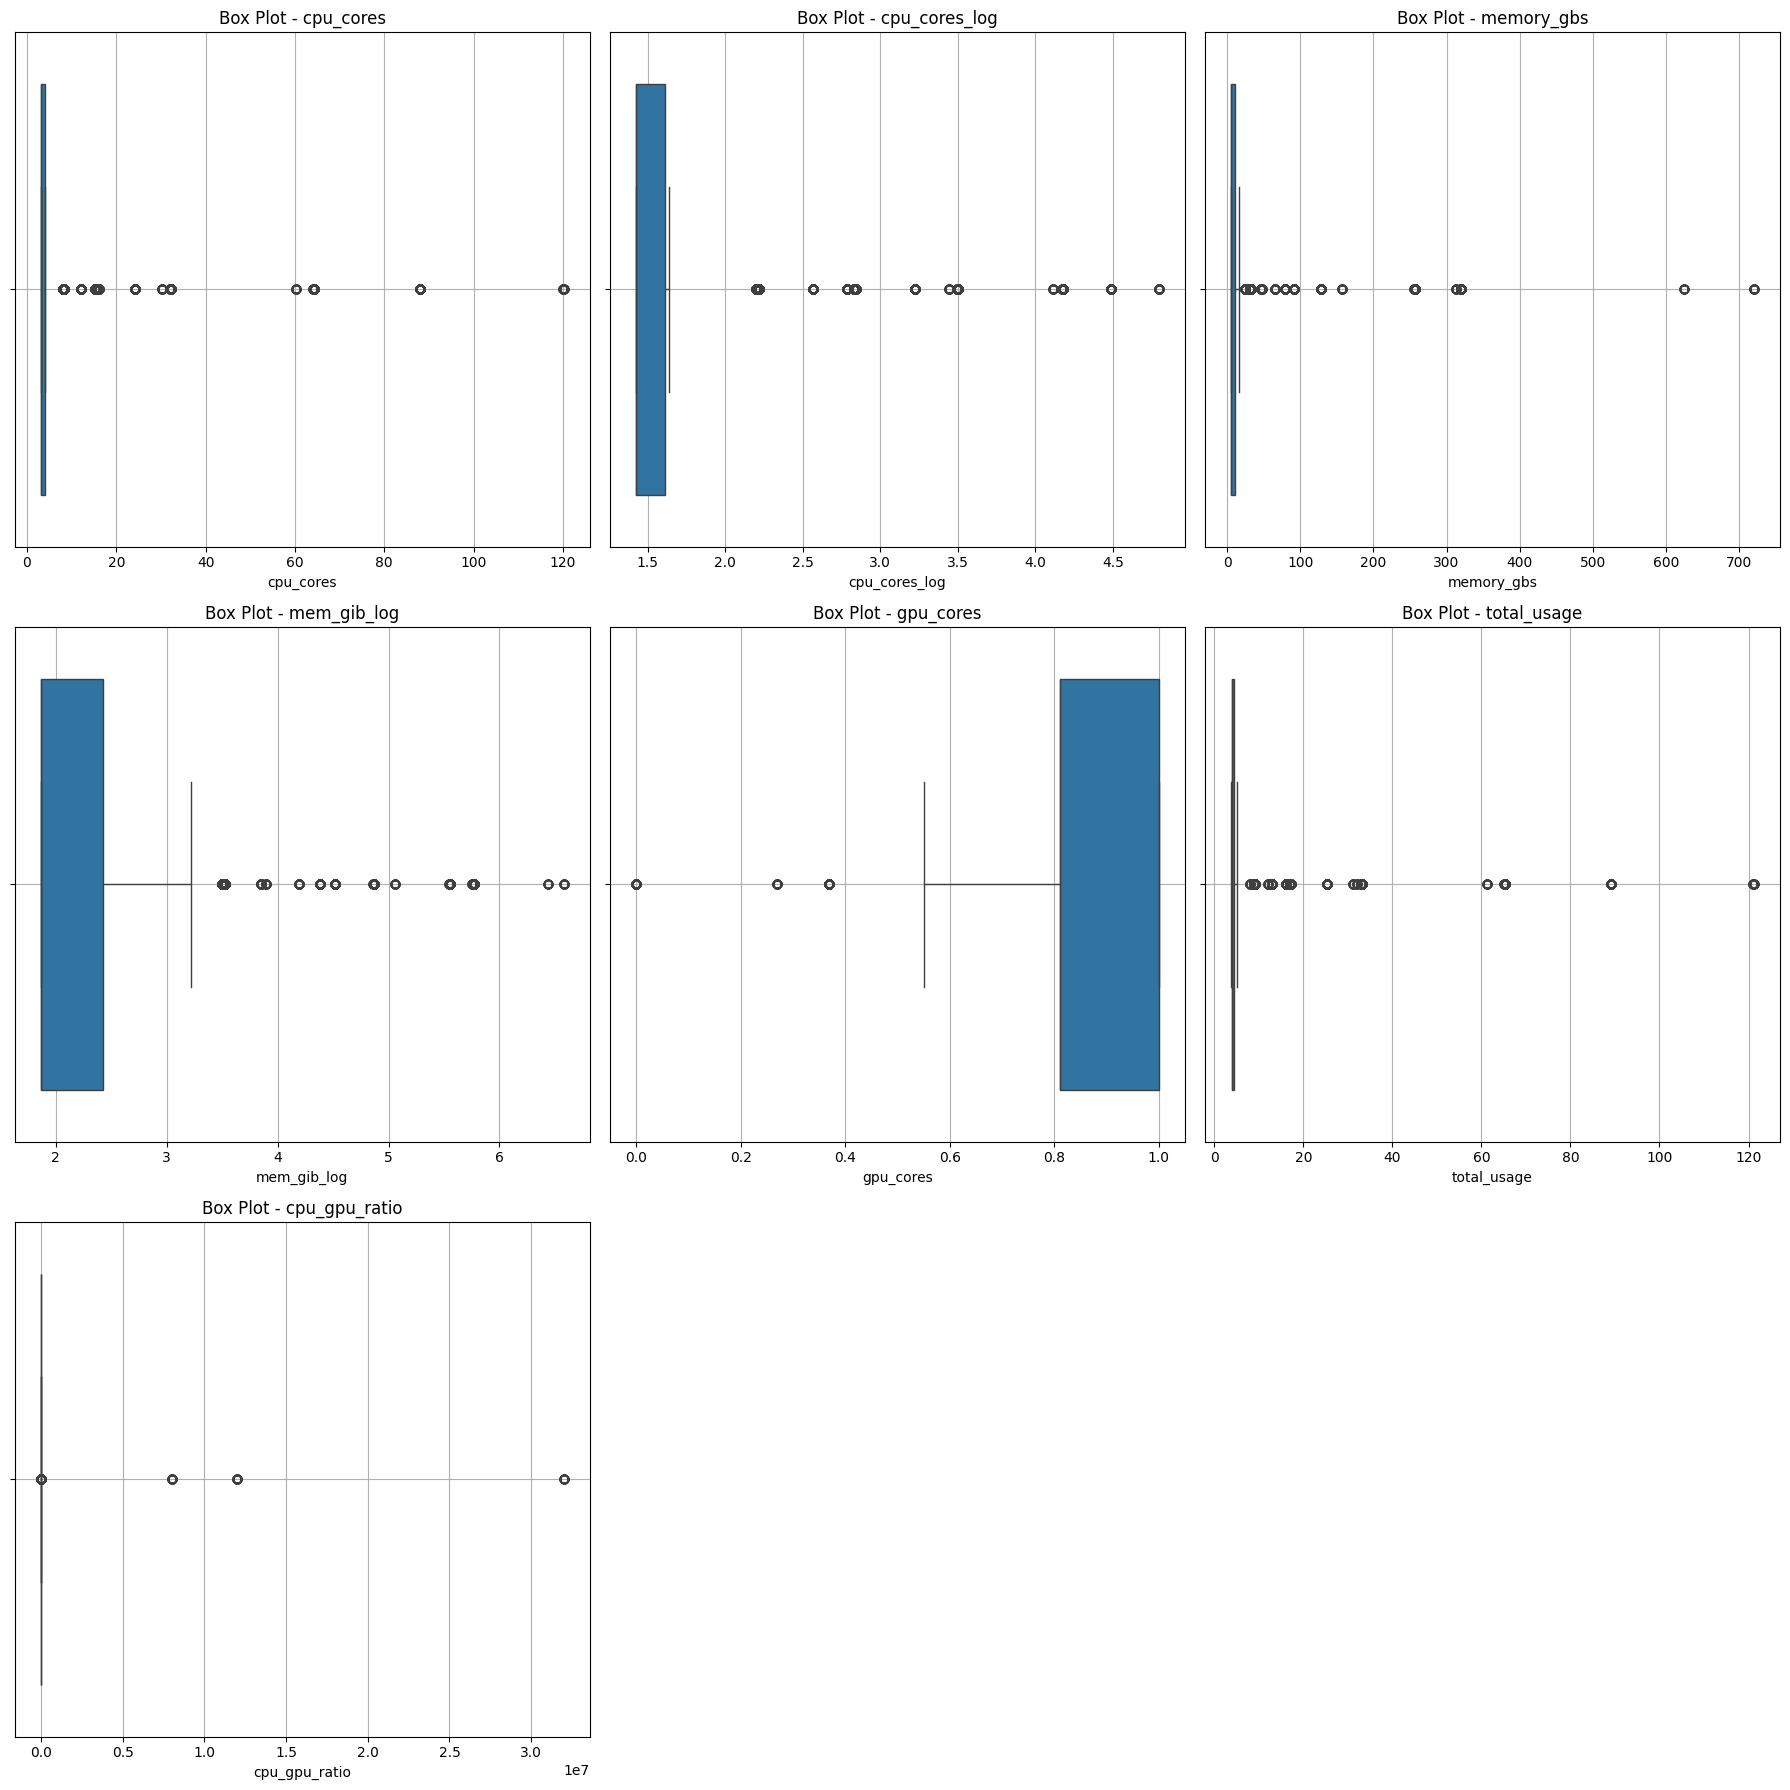

In [74]:
plot_boxplots(df, numeric_columns )

### Exportar resultados limpios para análisis

In [75]:
df.to_csv('data/cleaned_data.csv', index=False)

In [77]:
df.head()

,name,cpu_milli,memory_mib,num_gpu,gpu_milli,gpu_spec,qos,pod_phase,creation_time,deletion_time,scheduled_time,source_file,cpu_cores,gpu_cores,memory_gbs,total_usage,cpu_gpu_ratio,cpu_cores_log,mem_gib_log
15,openb-pod-0015,88000,327680,8,1000,0,Burstable,Succeeded,9437497.0,10769854.0,9437497.0,openb_pod_list_cpu0.csv,88.000,1.0,320.00000,89.000,87.999912,4.488636,5.771441
31,openb-pod-0031,3152,5600,1,1000,0,BE,Failed,9965463.0,9965645.0,9965463.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997,1.423590,1.866983
34,openb-pod-0034,3152,5600,1,1000,0,BE,Failed,9967204.0,9967404.0,9967204.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997,1.423590,1.866983
39,openb-pod-0039,3152,5600,1,1000,0,BE,Failed,9976185.0,9976497.0,9976185.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997,1.423590,1.866983
40,openb-pod-0040,3152,5600,1,1000,0,BE,Failed,9977555.0,9977866.0,9977555.0,openb_pod_list_cpu0.csv,3.152,1.0,5.46875,4.152,3.151997,1.423590,1.866983
